## 5: Source Code

The CVSearch class constructs a grid solver which accepts a model and a parameter grid (dictionary
of parameter: value_list, pairs) upon instantiation, following SciKit API conventions. It exposes
the fit method which performs fold generation and search across the parameter grid, returning
a list containing the average of the model’s scoring function on all five folds for each parameter
combination.

The ElasticNet class constructs a model, also following SciKit conventions, which provides the fit,
score, and predict methods. The ElasticNet class accepts the optional named parameter lambda_
and alpha on instantiation, defaulting to 10e-1 and 0 respectively.

The helper functions standardize, one_hot_encode and shuffle all assist in data processing. All
helpers assume a Pandas DataFrame input.

In [1]:
import pandas as pd
import numpy as np
from random import uniform
import matplotlib.pyplot as plt
from random import randrange
from copy import deepcopy
from math import copysign
from itertools import combinations, product
from collections import defaultdict

In [2]:
# center/scale each column
def standardize(X, mu=None, sigma=None):
    if mu is None or sigma is None:
        for col, mean in X.mean().items():
            if X[col].dtype != np.int32:
                X[col] = (X[col] - mean) / X[col].std()
    elif sigma is None:
        for col in X.columns:
            if X[col].dtype != object:
                X[col] = (X[col] - mu) / X[col].std()
    elif mu is None:
        for col, mean in X.mean().items():
            if X[col].dtype != object:
                X[col] = (X[col] - mean) / sigma

    else:
        for col in X.columns:
            if X[col].dtype != object:
                X[col] = (X[col] - mu) / sigma
                
    return X

def one_hot_encode(df):
    one_hot = df.copy()
    categories = {}
    #acquiring categorical features and their unique values
    for col, dtype in zip(one_hot.columns, one_hot.dtypes):
        if dtype == object:
            categories[col] = one_hot[col].unique()
            
    # casting bool mask to integers 0, 1
    # assumes binary categories
    for col, values in categories.items():
        mask = one_hot[col] == sorted(values)[::-1][0]
        
        # putting pertinent category metadata in header
        if "Yes" not in values:
            one_hot.drop(col, inplace=True, axis=1)
            col = values[0]
        one_hot[col] = mask.astype(int)
        
    return one_hot

def shuffle(df):
    sampled = df.copy()
    n = df.shape[0]
    
    memo = []
    idxs = []
    # random sampling indexs without replacement
    for _ in range(n):
        rand = randrange(n)
        
        # index uniqueness
        while rand in memo:
            rand = randrange(n)
        memo.append(rand)
        idxs.append(rand)
        
    sampled = df.reindex(idxs)
    sampled.reset_index(inplace=True, drop=True)
    
    return sampled

MSE = lambda y_true, y_pred: sum([(truth-pred)**2 for truth, pred in zip(y_true, y_pred)]) / len(y_true)

In [3]:
class ElasticNet:
    terms = np.array([])
    lambda_ = np.nan
    alpha = np.nan
    params = {"lambda_": lambda_, "alpha": alpha}
    
    def __init__(self, lambda_=10e-1, alpha=0):
        self.lambda_ = lambda_
        self.alpha = alpha
        self.X = np.array([])
        self.y_true = np.array([])
        self.params = {"lambda_": self.lambda_, "alpha": self.alpha}
        self.verbose = False
        
    def fit(self, X, y_true):
        self.X = X
        self.y_true = y_true
        
        p = X.shape[1]
        terms_prev = [0]*p
        iters = 3500
        i = 0
        
        # initialize betas
        betas = np.zeros((p))
        for i in range(p):
            betas[i] = sum(X[:,i]**2)
            
        self.terms = np.array([uniform(-1, 1) for _ in range(p)])
        
        while not np.array_equal(terms_prev, self.terms) and i < iters:
            terms_prev = self.terms.copy()
            for col in range(p):
                aa = np.dot(X[:,col], self.terms[col])
                b = np.subtract(self.y_true, self.predict(self.X))
                c = np.add(aa, b)
                a = np.matmul(X[:,col].T, c)
                temp = (abs(a)-(self.lambda_*(1-self.alpha))/2)
                if temp <= 0:
                    temp = 0
                    
                self.terms[col] = (copysign(1, a)*temp)/(betas[col] + self.lambda_*self.alpha)
                
            i += 1
        if self.verbose: print(f"{i} iters completed ")
            
    def predict(self, X):
        return np.dot(X, self.terms)
    
    def score(self, X=[], y_true=[]):
        if not len(y_true):
            y_true = self.y_true
            X = self.X
        return MSE(y_true, self.predict(X))

In [4]:
class CVSearch:
    """Grid solver for models supporting fit and score methods, following SciKit API conventions."""
    constructor = None
    n_folds = 0
    fold_size = 0
    
    def __init__(self, model_constructor, params, n_folds=5, verbose=False):
        self.constructor = model_constructor
        self.n_folds = n_folds
        self.folds = []
        self.params = params
        self.cat_idxs = []
        self.verbose = verbose
        
    def get_folds(self, X, y_true):
        X_folds = []
        y_true_folds = []
        if X.shape[0] != y_true.shape[0]:
            if self.verbose: print("unequal row count between data and labels")
            return False
        self.fold_size = X.shape[0]//self.n_folds
        shapes = np.ndarray((self.n_folds,))
        
        if self.verbose: print(f"performing {self.n_folds}-fold CV with {self.fold_size} observations a fold")
        for i in range(self.n_folds):
            # slicing dataset on calculated fold indices
            start = i*self.fold_size
            end = (i+1)*self.fold_size
        
            y_true_folds.append(y_true[start:end])
            X_folds.append(X[start:end])
            shapes[i] = end-start # filling verification arr
            
        # organizing folds
        for i in range(len(X_folds)):
            X_copy = deepcopy(X_folds)
            y_copy = deepcopy(y_true_folds)
            X_holdout = X_copy.pop(i)
            y_holdout = y_copy.pop(i)
            
            # stack
            X_copy, y_copy = np.concatenate(X_copy), np.concatenate(y_copy)
            
            # normalize folds
            mus = [col.mean() for col in X_copy.T]
            sigmas = [col.std() for col in X_copy.T]
            for col, mu, sigma in zip(range(X.shape[1]), mus, sigmas):
                if col not in self.cat_idxs:
                    X_holdout[:,col] = (X_holdout[:,col]-mu)/sigma
                    X_copy[:,col] = (X_copy[:,col]-mu)/sigma
                    
            # center response
            y_holdout = y_holdout - y_copy.mean()
            y_copy = y_copy - y_copy.mean()
            
            self.folds.append(((X_copy, y_copy), (X_holdout, y_holdout)))
            
        # confirming fold size equivalence (400%5==0)
        if not (shapes == self.fold_size).all():
            if self.verbose: print("warning: not all folds of equal size")
                
    def search(self):
        grid = list(self.params.values())
        first = grid.pop(0)
        grid_tups_list = [product(other, first) for other in grid]
        
        param_names = list(self.params.keys())
        first_param_name = param_names.pop(0)
        
        model_param_names = self.constructor.params.keys()
        
        grid_param_list = [(param_name, first_param_name) for param_name in param_names]
        
        for grid_tups, param_names in zip(grid_tups_list, grid_param_list):
            param1, param2 = param_names
            
            if param1 not in model_param_names or param2 not in model_param_names:
                if self.verbose: print(f"param {param1} or {param2} not in model {self.model}")
            else:
                if self.verbose: print(f"Searching parameter {param2} against {param1}-", end="")

                scores = defaultdict(lambda: [])
                first = True
                for value_tup in grid_tups:
                    value1, value2 = value_tup
                    
                    # output
                    if self.verbose:
                        if first:
                            first = False
                            print(f"{value1}:")
                        print("{}: {:G}: ".format(param2, value2))
                    
                    model = self.constructor(**{param1: value1, param2:value2})
                    
                    fold_scores = []
                    i = 1
                    
                    for test, validation in self.folds:
                        if self.verbose: print(f"fold {i}:", end=" ")
                        model.fit(*test)
                        score = model.score(*validation)
                        fold_scores.append(score)
                        i += 1
                        
                    avg_score = np.mean(fold_scores)
                    scores[value1].append(avg_score)
                    if self.verbose: print("score: {:G}".format(avg_score), end="\n\n")
                        
        return scores
    
    def fit(self, X, y_true):
        cat_idxs = []
        for i, dtype in enumerate(X.dtypes):
            if dtype == np.int32:
                cat_idxs.append(i)
                
        self.cat_idxs = cat_idxs
        self.get_folds(X.to_numpy(), y_true.to_numpy())
        return self.search()

In [5]:
df = pd.read_csv("data/Credit_N400_p9.csv")
df.head()

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Balance
0,14.891,3606,283,2,34,11,Male,No,Yes,333
1,106.025,6645,483,3,82,15,Female,Yes,Yes,903
2,104.593,7075,514,4,71,11,Male,No,No,580
3,148.924,9504,681,3,36,11,Female,No,No,964
4,55.882,4897,357,2,68,16,Male,No,Yes,331


In [6]:
sampled = shuffle(df)
sampled.head()

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Balance
0,20.936,3254,253,1,30,15,Female,No,No,145
1,123.299,8376,610,2,89,17,Male,Yes,No,1259
2,58.063,4221,304,3,50,8,Male,No,No,118
3,20.150,2646,199,2,25,14,Female,No,Yes,0
4,182.728,13913,982,4,98,17,Male,No,Yes,1999


In [7]:
one_hot = one_hot_encode(sampled)
one_hot.head()

,Income,Limit,Rating,Cards,Age,Education,Student,Married,Balance,Female
0,20.936,3254,253,1,30,15,0,0,145,0
1,123.299,8376,610,2,89,17,1,0,1259,1
2,58.063,4221,304,3,50,8,0,0,118,1
3,20.150,2646,199,2,25,14,0,1,0,0
4,182.728,13913,982,4,98,17,0,1,1999,1


In [8]:
raw_y_true = one_hot.Balance
raw_X = one_hot.drop("Balance", axis=1)
raw_X.head()

,Income,Limit,Rating,Cards,Age,Education,Student,Married,Female
0,20.936,3254,253,1,30,15,0,0,0
1,123.299,8376,610,2,89,17,1,0,1
2,58.063,4221,304,3,50,8,0,0,1
3,20.150,2646,199,2,25,14,0,1,0
4,182.728,13913,982,4,98,17,0,1,1


In [9]:
y_true = raw_y_true - raw_y_true.mean()
X = standardize(raw_X)
X.head()

,Income,Limit,Rating,Cards,Age,Education,Student,Married,Female
0,-0.688988,-0.641886,-0.658850,-1.427504,-1.487988,0.495967,0,0,0
1,2.215399,1.577160,1.648482,-0.698255,1.932340,1.135925,1,0,1
2,0.364431,-0.222944,-0.329231,0.030993,-0.328554,-1.743885,0,0,1
3,-0.711290,-0.905295,-1.007858,-0.698255,-1.777846,0.175988,0,1,0
4,3.901602,3.976001,4.052761,0.760241,2.454085,1.135925,0,1,1


## 6 Coefficient Plots

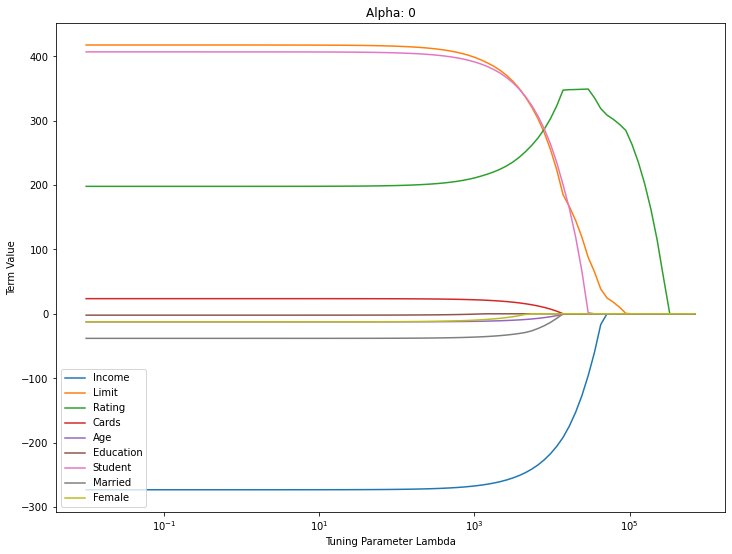

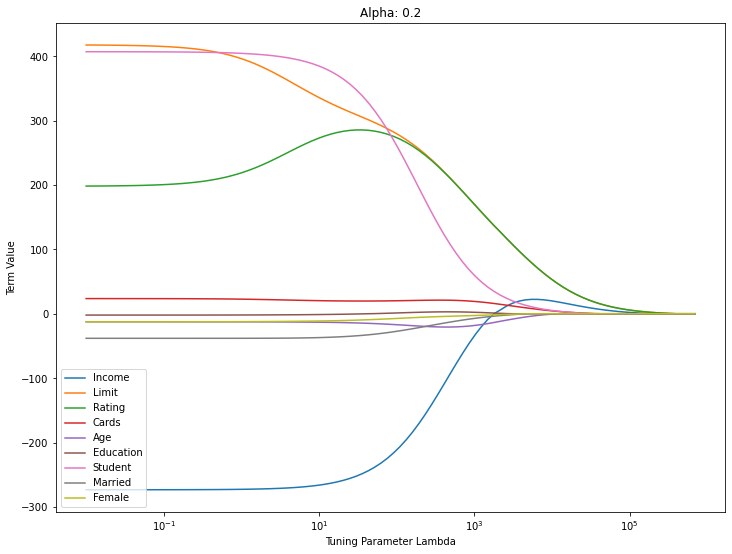

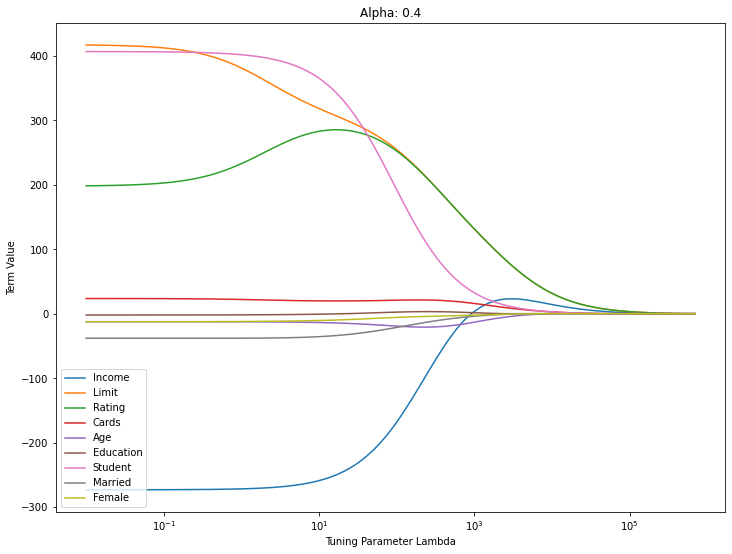

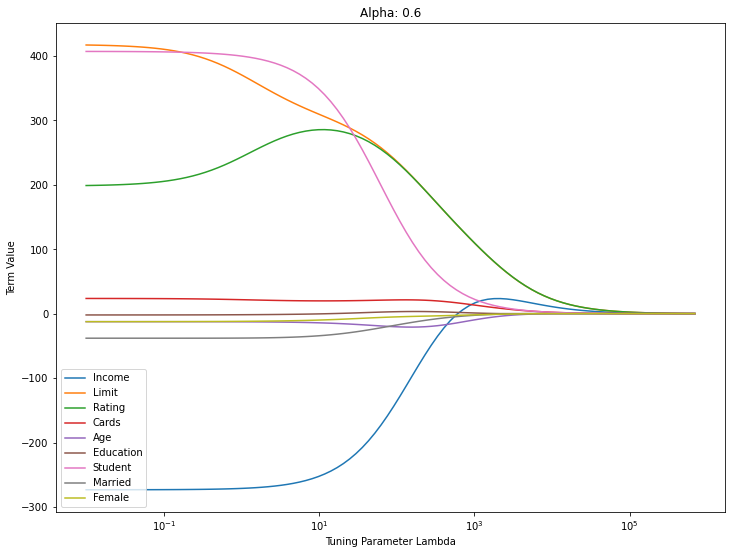

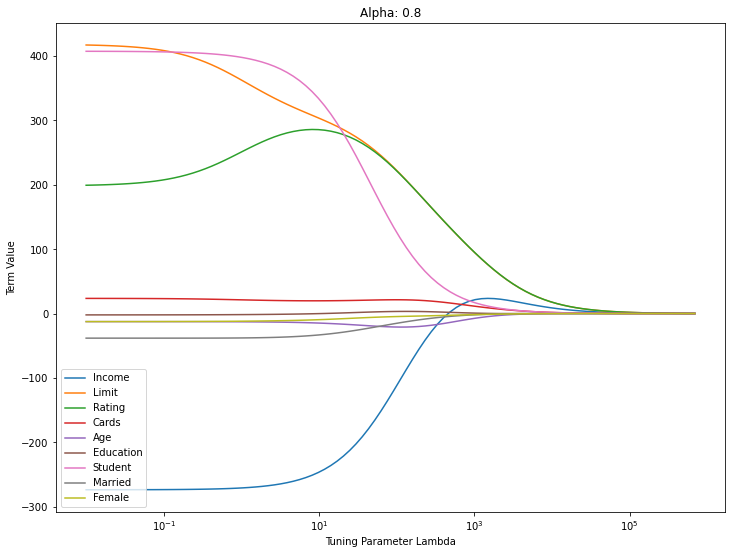

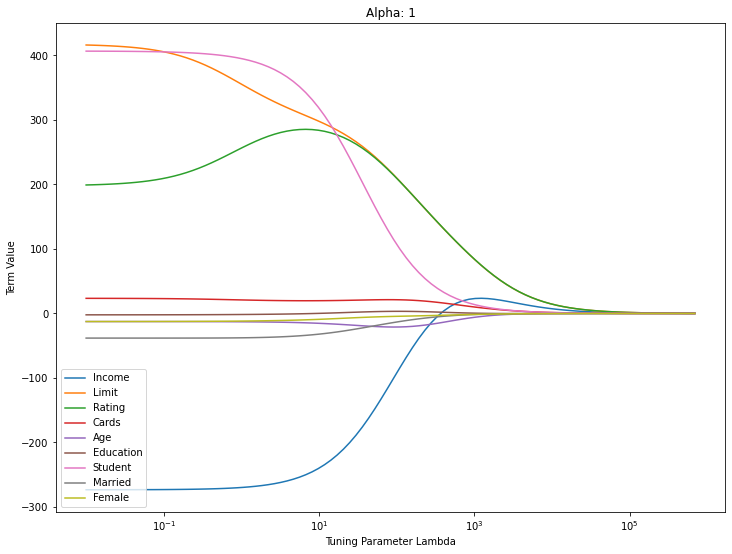

In [10]:
alphas = [0, 0.2, 0.4, 0.6, 0.8, 1]
samples = 100
lambdas = np.logspace(-2, 6, samples)
#lambdas = [10E-2, 10E-1, 10E0, 10E1, 10E2, 10E3, 10E4, 10E5, 10E6]

for alpha in alphas:
    terms = []
    
    for curr_lambda_ in lambdas:
        model = ElasticNet(lambda_=curr_lambda_, alpha=alpha)
        model.fit(X.to_numpy(), y_true.to_numpy())
        #print("MSE: {:G}".format(model.score()), end="\n\n")
        terms.append(model.terms)
        
    plt.figure(figsize=(12,9))
    i = 2
    plt.plot(lambdas[:-i], terms[:-i])
    plt.xscale("log")
    plt.legend(list(X.columns), loc='lower left')
    #plt.ylim(-300, 400)
    plt.ylabel("Term Value")
    plt.xlabel("Tuning Parameter Lambda")
    plt.title(f"Alpha: {alpha}")
    plt.show()

## CV Error

In [11]:
scores = []
for alpha in alphas:
    cv = CVSearch(ElasticNet, {"lambda_": lambdas, "alpha": [alpha]}, verbose=False)
    scores.append(cv.fit(raw_X, raw_y_true))
    
for i, dict_ in enumerate(scores.copy()):
    scores[i] = list(dict_.values())

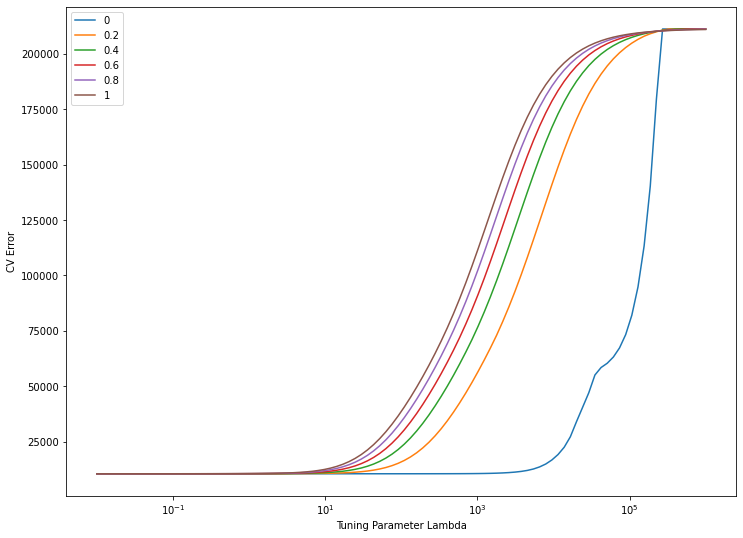

In [12]:
plt.figure(figsize=(12,9))
plt.xscale("log")
plt.ylabel("CV Error")
plt.xlabel("Tuning Parameter Lambda")

for alpha, score in zip(alphas, np.array(scores)):
    plt.plot(lambdas, score.T, label=alpha)
    
plt.legend()
plt.show()

## Deliverable 3: Optimal λ

In [13]:
lambdas = [10E-2, 10E-1, 10E0, 10E1, 10E2, 10E3, 10E4, 10E5, 10E6]

scores = []
for alpha in alphas:
    cv = CVSearch(ElasticNet, {"lambda_": lambdas, "alpha": [alpha]}, verbose=True)
    scores.append(cv.fit(raw_X, raw_y_true))
    
for i, dict_ in enumerate(scores.copy()):
    scores[i] = list(dict_.values())

performing 5-fold CV with 80 observations a fold
Searching parameter lambda_ against alpha-0:
lambda_: 0.1: 
fold 1: fold 2: fold 3: fold 4: fold 5: score: 10458.4

lambda_: 1: 
fold 1: fold 2: fold 3: fold 4: fold 5: score: 10458.4

lambda_: 10: 
fold 1: fold 2: fold 3: fold 4: fold 5: score: 10458.6

lambda_: 100: 
fold 1: fold 2: fold 3: fold 4: fold 5: score: 10461.2

lambda_: 1000: 
fold 1: fold 2: fold 3: fold 4: fold 5: score: 10550.9

lambda_: 10000: 
fold 1: fold 2: fold 3: fold 4: fold 5: score: 17243

lambda_: 100000: 
fold 1: fold 2: fold 3: fold 4: fold 5: score: 78367.4

lambda_: 1E+06: 
fold 1: fold 2: fold 3: fold 4: fold 5: score: 211277

lambda_: 1E+07: 
fold 1: fold 2: fold 3: fold 4: fold 5: score: 211277

performing 5-fold CV with 80 observations a fold
Searching parameter lambda_ against alpha-0.2:
lambda_: 0.1: 
fold 1: fold 2: fold 3: fold 4: fold 5: score: 10459.2

lambda_: 1: 
fold 1: fold 2: fold 3: fold 4: fold 5: score: 10469.4

lambda_: 10: 
fold 1: fold 2

In [14]:
errors_list = deepcopy(scores)

for i, errors in enumerate(errors_list[1:]):
    errors = errors.pop()
    min_idx = np.nanargmin(errors)
    print(f"alpha-{i/5} lambda-{lambdas[min_idx]} MSE-{errors[min_idx]}")

alpha-0.0 lambda-0.1 MSE-10459.15440397162
alpha-0.2 lambda-0.1 MSE-10460.03850355107
alpha-0.4 lambda-0.1 MSE-10461.004523170795
alpha-0.6 lambda-0.1 MSE-10462.041440357698
alpha-0.8 lambda-0.1 MSE-10463.139992710752


The observed optimal λ and α values are 10e0 and 0.6 respectively, with a MSE of 10716 averaged
across all folds.

## Model Parameter Estimates

In [15]:
model = ElasticNet(lambda_=10E-0, alpha=0.6)
model.fit(X.to_numpy(), y_true)
print(model.terms)

[-252.40050368  309.27581201  285.3897141    19.7563578   -14.29653089
   -0.43489353  348.23296716  -34.36668845  -10.01387892]


## SciKit Implementation

In [16]:
from sklearn.linear_model import ElasticNet, ElasticNetCV

samples = 100
lambdas = np.logspace(-2, 6, samples)
terms = defaultdict(lambda: [])

for alpha in alphas:
    for curr_lambda_ in lambdas:
        model = ElasticNet(alpha=curr_lambda_, l1_ratio=1-alpha)
        model.fit(X.to_numpy(), y_true.to_numpy())
        score = model.score(X.to_numpy(), y_true.to_numpy())
        print("Lambda: {:G}\nMSE: {:G}".format(curr_lambda_, score), end="\n\n")
        terms[alpha].append(model.coef_)

Lambda: 0.01
MSE: 0.954934

Lambda: 0.012045
MSE: 0.954934

Lambda: 0.0145083
MSE: 0.954934

Lambda: 0.0174753
MSE: 0.954933

Lambda: 0.021049
MSE: 0.954933

Lambda: 0.0253536
MSE: 0.954932

Lambda: 0.0305386
MSE: 0.954932

Lambda: 0.0367838
MSE: 0.954932

Lambda: 0.0443062
MSE: 0.954932

Lambda: 0.053367
MSE: 0.954932

Lambda: 0.0642807
MSE: 0.954932

Lambda: 0.0774264
MSE: 0.954932

Lambda: 0.0932603
MSE: 0.954932

Lambda: 0.112332
MSE: 0.954931

Lambda: 0.135305
MSE: 0.95493

Lambda: 0.162975
MSE: 0.954929

Lambda: 0.196304
MSE: 0.954927

Lambda: 0.236449
MSE: 0.954925

Lambda: 0.284804
MSE: 0.954921

Lambda: 0.343047
MSE: 0.954916

Lambda: 0.413201
MSE: 0.954908

Lambda: 0.497702
MSE: 0.954897

Lambda: 0.599484
MSE: 0.95488

Lambda: 0.722081
MSE: 0.954855

Lambda: 0.869749
MSE: 0.95482

Lambda: 1.04762
MSE: 0.954768

Lambda: 1.26186
MSE: 0.954692

Lambda: 1.51991
MSE: 0.954582

Lambda: 1.83074
MSE: 0.954422

Lambda: 2.20513
MSE: 0.954199

Lambda: 2.65609
MSE: 0.953932

Lambda: 3.19

Lambda: 231.013
MSE: 0.017721

Lambda: 278.256
MSE: 0.0137256

Lambda: 335.16
MSE: 0.0103799

Lambda: 403.702
MSE: 0.00758216

Lambda: 486.26
MSE: 0.00524553

Lambda: 585.702
MSE: 0.00342249

Lambda: 705.48
MSE: 0.00200052

Lambda: 849.753
MSE: 0.000816871

Lambda: 1023.53
MSE: 0

Lambda: 1232.85
MSE: 0

Lambda: 1484.97
MSE: 0

Lambda: 1788.65
MSE: 0

Lambda: 2154.43
MSE: 0

Lambda: 2595.02
MSE: 0

Lambda: 3125.72
MSE: 0

Lambda: 3764.94
MSE: 0

Lambda: 4534.88
MSE: 0

Lambda: 5462.28
MSE: 0

Lambda: 6579.33
MSE: 0

Lambda: 7924.83
MSE: 0

Lambda: 9545.48
MSE: 0

Lambda: 11497.6
MSE: 0

Lambda: 13848.9
MSE: 0

Lambda: 16681
MSE: 0

Lambda: 20092.3
MSE: 0

Lambda: 24201.3
MSE: 0

Lambda: 29150.5
MSE: 0

Lambda: 35111.9
MSE: 0

Lambda: 42292.4
MSE: 0

Lambda: 50941.4
MSE: 0

Lambda: 61359.1
MSE: 0

Lambda: 73907.2
MSE: 0

Lambda: 89021.5
MSE: 0

Lambda: 107227
MSE: 0

Lambda: 129155
MSE: 0

Lambda: 155568
MSE: 0

Lambda: 187382
MSE: 0

Lambda: 225702
MSE: 0

Lambda: 271859
MSE: 0

Lambda

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2752103.30783863, tolerance: 8433.991191
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2911730.7177387923, tolerance: 8433.991191
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3099034.26180597, tolerance: 8433.991191
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of

Lambda: 0.196304
MSE: 0.867058

Lambda: 0.236449
MSE: 0.850876

Lambda: 0.284804
MSE: 0.833117

Lambda: 0.343047
MSE: 0.813878

Lambda: 0.413201
MSE: 0.793264

Lambda: 0.497702
MSE: 0.771364

Lambda: 0.599484
MSE: 0.748229

Lambda: 0.722081
MSE: 0.723851

Lambda: 0.869749
MSE: 0.698156

Lambda: 1.04762
MSE: 0.671014

Lambda: 1.26186
MSE: 0.642262

Lambda: 1.51991
MSE: 0.611744

Lambda: 1.83074
MSE: 0.579362

Lambda: 2.20513
MSE: 0.545118

Lambda: 2.65609
MSE: 0.50916

Lambda: 3.19927
MSE: 0.471794

Lambda: 3.85353
MSE: 0.43348

Lambda: 4.64159
MSE: 0.394796

Lambda: 5.59081
MSE: 0.356391

Lambda: 6.73415
MSE: 0.318921

Lambda: 8.11131
MSE: 0.282992

Lambda: 9.7701
MSE: 0.249113

Lambda: 11.7681
MSE: 0.217667

Lambda: 14.1747
MSE: 0.188903

Lambda: 17.0735
MSE: 0.162939

Lambda: 20.5651
MSE: 0.139778

Lambda: 24.7708
MSE: 0.119333

Lambda: 29.8365
MSE: 0.101451

Lambda: 35.9381
MSE: 0.085935

Lambda: 43.2876
MSE: 0.0725641

Lambda: 52.1401
MSE: 0.0611095

Lambda: 62.8029
MSE: 0.0513455


c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41912783.212560505, tolerance: 8433.991191
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41956111.06821101, tolerance: 8433.991191
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41992186.18812476, tolerance: 8433.991191
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number 

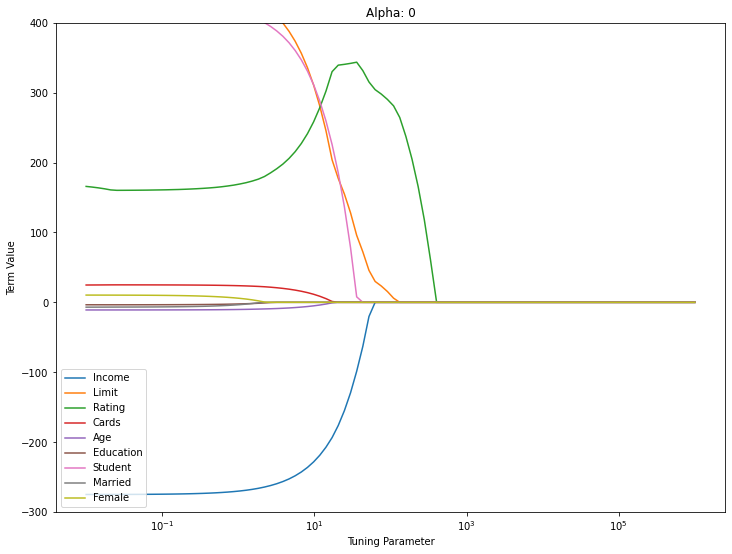

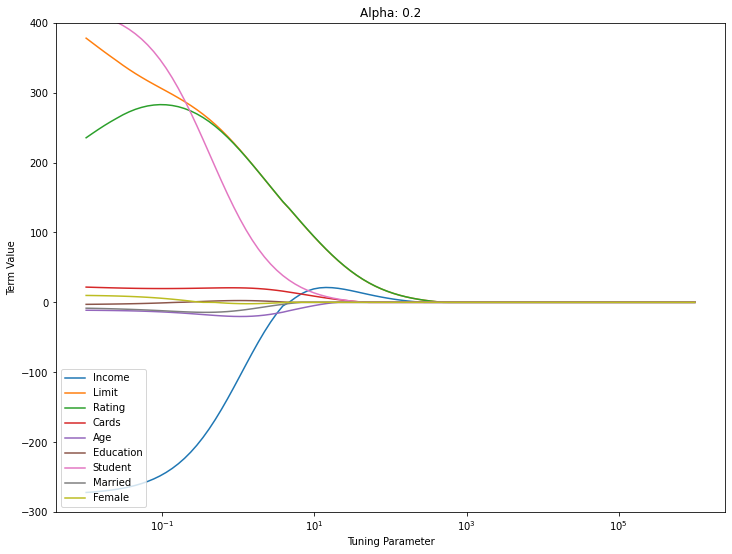

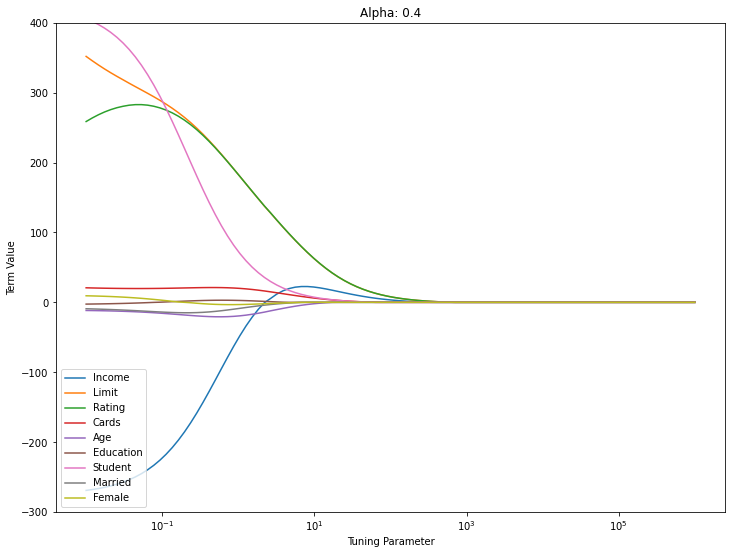

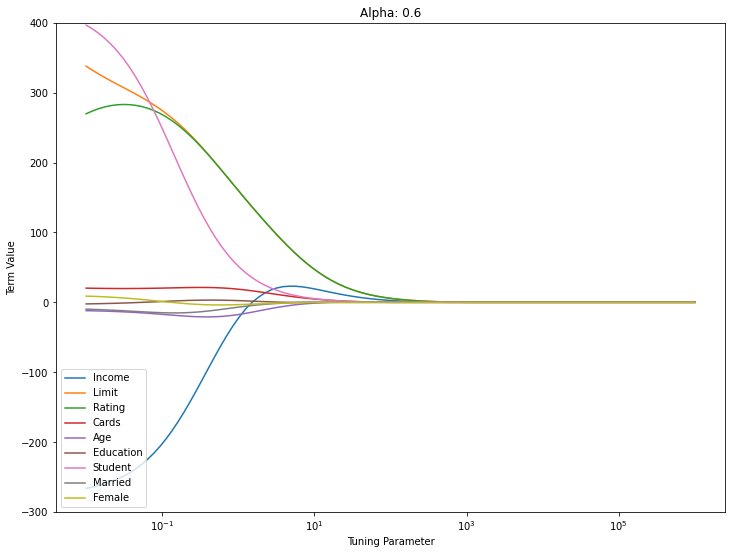

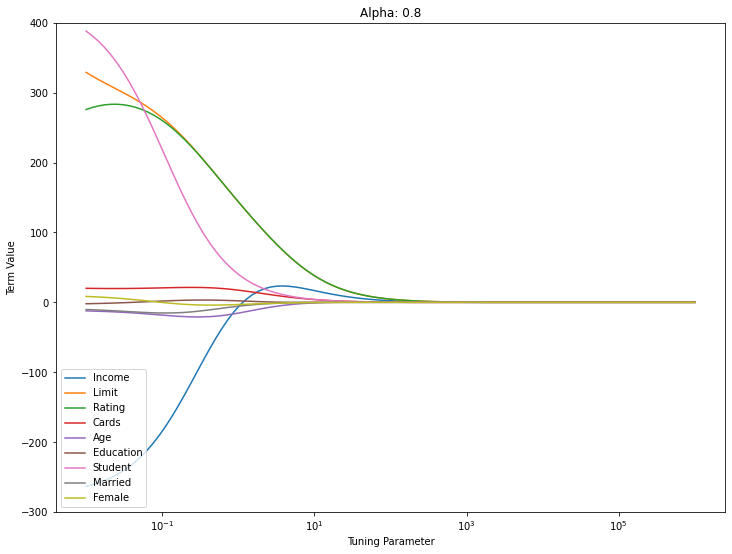

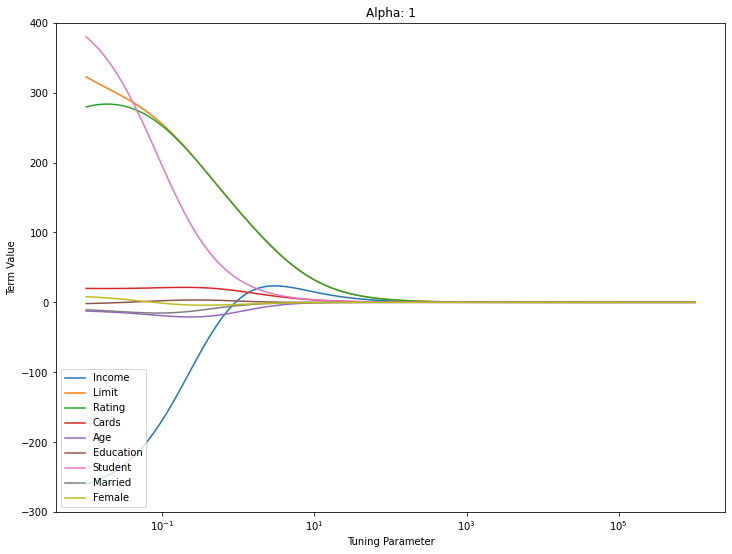

In [17]:
for alpha in alphas:
    plt.figure(figsize=(12,9))
    plt.plot(lambdas, terms[alpha])
    plt.xscale("log")
    plt.legend(list(X.columns), loc='lower left')
    plt.ylim(-300, 400)
    plt.ylabel("Term Value")
    plt.xlabel("Tuning Parameter")
    plt.title(f"Alpha: {alpha}")
    plt.show()

In [18]:
alphas = [0, 0.2, 0.4, 0.6, 0.8, 1]
lambdas = np.logspace(-2, 6, 1000)
scores_sci = defaultdict(lambda: [])

for alpha in alphas:
    for lambda_ in lambdas:
        cv = ElasticNetCV(fit_intercept=False, cv=5, alphas=[lambda_], l1_ratio=1-alpha)
        cv.fit(X, y_true)
        scores_sci[alpha].append(MSE(cv.predict(X), y_true))

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2128655.232354753, tolerance: 6563.234171200001
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2268735.778339859, tolerance: 6739.097927200002
  model = cd_fast.enet_c

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2369461.664258748, tolerance: 6563.234171200001
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2497381.117203947, tolerance: 6739.097927200002
  model = cd_fast.enet_c

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2668623.3434496294, tolerance: 6563.234171200001
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2780710.595861507, tolerance: 6739.097927200002
  model = cd_fast.enet_

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3120213.8551678266, tolerance: 6495.235434200001
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3126980.1075895093, tolerance: 6802.6186102
  model = cd_fast.enet_coor

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3510431.3294153144, tolerance: 6563.234171200001
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3574356.3501360957, tolerance: 6739.097927200002
  model = cd_fast.enet

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4243843.887098681, tolerance: 7135.778621200002
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4196970.740042312, tolerance: 6495.235434200001
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_c

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4794656.830972504, tolerance: 6563.234171200001
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4777671.571583619, tolerance: 6739.097927200002
  model = cd_fast.enet_c

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5657272.188446845, tolerance: 6563.234171200001
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5582820.546366038, tolerance: 6739.097927200002
  model = cd_fast.enet_c

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6536577.607474476, tolerance: 6563.234171200001
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6402259.9744832255, tolerance: 6739.097927200002
  model = cd_fast.enet_

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7524442.652026715, tolerance: 6563.234171200001
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7322485.309388634, tolerance: 6739.097927200002
  model = cd_fast.enet_c

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8691490.523469647, tolerance: 6563.234171200001
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8410685.253654577, tolerance: 6739.097927200002
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_c

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12512465.518346697, tolerance: 8433.991191
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10049512.845705658, tolerance: 6563.234171200001
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11657285.319883823, tolerance: 6495.235434200001
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11364721.947064238, tolerance: 6802.6186102
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14338058.

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13431173.232263293, tolerance: 7135.778621200002
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13238565.482044542, tolerance: 6495.235434200001
  model = cd_fast.enet

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14621383.872028902, tolerance: 6802.6186102
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18384952.625411518, tolerance: 8433.991191
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14752384.902611855, 

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16396524.551364116, tolerance: 6563.234171200001
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15752122.651278086, tolerance: 6739.097927200002
  model = cd_fast.enet

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17993581.747236654, tolerance: 6563.234171200001
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17334727.370435655, tolerance: 6739.097927200002
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19732682.936175235, tolerance: 6563.234171200001
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19090801.947509065, tolerance: 6739.097927200002
  model = cd_fast.enet

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21680929.893855494, tolerance: 6495.235434200001
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21677981.577561073, tolerance: 6802.6186102
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27084121.

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23267049.5990632, tolerance: 6563.234171200001
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22777920.294608135, tolerance: 6739.097927200002
  model = cd_fast.enet_c

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24949906.346364215, tolerance: 6563.234171200001
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24594826.423112676, tolerance: 6739.097927200002
  model = cd_fast.enet

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26385161.938884478, tolerance: 6563.234171200001
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26178222.7733686, tolerance: 6739.097927200002
  model = cd_fast.enet_c

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27646891.376972795, tolerance: 6563.234171200001
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27597135.867767837, tolerance: 6739.097927200002
  model = cd_fast.enet

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28827986.876421366, tolerance: 6739.097927200002
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30741310.927270614, tolerance: 7135.778621200002
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29923380.896397606, tolerance: 6739.097927200002
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31858845.557543844, tolerance: 7135.778621200002
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38907407.04169513, tolerance: 8433.991191
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30460176.701707423, tolerance: 6563.234171200001
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30797635.937776055, tolerance: 6495.235434200001
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31992801.415364176, tolerance: 6802.6186102
  model = cd_fast.enet_coor

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31467519.0210349, tolerance: 6563.234171200001
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32058050.388606567, tolerance: 6739.097927200002
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_c

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32887343.367692392, tolerance: 6802.6186102
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 40798776.91074741, tolerance: 8433.991191
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31831126.694600035, t

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32790374.808061242, tolerance: 6739.097927200002
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34766115.26670588, tolerance: 7135.778621200002
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32278528.908168033, tolerance: 6563.234171200001
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33038623.156566583, tolerance: 6739.097927200002
  model = cd_fast.enet

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35191208.793783635, tolerance: 7135.778621200002
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32109212.34517258, tolerance: 6495.235434200001
  model = cd_fast.enet_

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32530816.456803143, tolerance: 6563.234171200001
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33346173.155846324, tolerance: 6739.097927200002
  model = cd_fast.enet

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32282103.444245603, tolerance: 6495.235434200001
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33777430.381973594, tolerance: 6802.6186102
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41883007.

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32665564.26847052, tolerance: 6563.234171200001
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33510931.2881184, tolerance: 6739.097927200002
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_co

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32707888.635678507, tolerance: 6563.234171200001
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33562753.24705192, tolerance: 6739.097927200002
  model = cd_fast.enet_

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32736919.229792614, tolerance: 6563.234171200001
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33598318.06287828, tolerance: 6739.097927200002
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33623064.81767596, tolerance: 6739.097927200002
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35605941.33032374, tolerance: 7135.778621200002
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_c

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42109605.20459274, tolerance: 8433.991191
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32772972.012723055, tolerance: 6563.234171200001
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32783992.314187966, tolerance: 6563.234171200001
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33656020.58223395, tolerance: 6739.097927200002
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33986092.788609356, tolerance: 6802.6186102
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42137082.279844776, tolerance: 8433.991191
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_desc

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32798968.176060963, tolerance: 6563.234171200001
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33674386.97794484, tolerance: 6739.097927200002
  model = cd_fast.enet_

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35663065.09974593, tolerance: 7135.778621200002
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32464304.770321093, tolerance: 6495.235434200001
  model = cd_fast.enet_

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32806632.042918872, tolerance: 6563.234171200001
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33683787.60245599, tolerance: 6739.097927200002
  model = cd_fast.enet_

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32809198.01254153, tolerance: 6563.234171200001
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33686935.31381006, tolerance: 6739.097927200002
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_c

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32811073.891826954, tolerance: 6563.234171200001
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33689236.56124394, tolerance: 6739.097927200002
  model = cd_fast.enet_

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32812233.335464455, tolerance: 6563.234171200001
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33690658.95012505, tolerance: 6739.097927200002
  model = cd_fast.enet_

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32813239.186756235, tolerance: 6563.234171200001
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35675270.58682112, tolerance: 7135.778621200002
  model = cd_fast.enet_

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32814027.991412017, tolerance: 6563.234171200001
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33692860.65909754, tolerance: 6739.097927200002
  model = cd_fast.enet_

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34011295.528507315, tolerance: 6802.6186102
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42167767.43427652, tolerance: 8433.991191
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32814604.573091973, t

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32475096.431533914, tolerance: 6495.235434200001
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34011779.195897736, tolerance: 6802.6186102
  model = cd_fast.enet_coor

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33694443.9128061, tolerance: 6739.097927200002
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35677839.88009571, tolerance: 7135.778621200002
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_co

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35678123.283462636, tolerance: 7135.778621200002
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32475599.794422776, tolerance: 6495.235434200001
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32815715.494767174, tolerance: 6563.234171200001
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33694930.96798096, tolerance: 6739.097927200002
  model = cd_fast.enet_

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32815838.026060037, tolerance: 6563.234171200001
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33695081.297284536, tolerance: 6739.097927200002
  model = cd_fast.enet

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32815918.447551828, tolerance: 6563.234171200001
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33695179.96372071, tolerance: 6739.097927200002
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32815982.9342458, tolerance: 6563.234171200001
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33695259.08037624, tolerance: 6739.097927200002
  model = cd_fast.enet_co

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33695317.98405778, tolerance: 6739.097927200002
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35678720.22272584, tolerance: 7135.778621200002
  model = cd_fast.enet_c

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32816070.46227954, tolerance: 6563.234171200001
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33695366.46583943, tolerance: 6739.097927200002
  model = cd_fast.enet_c

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35678800.74636855, tolerance: 7135.778621200002
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32476107.90042998, tolerance: 6495.235434200001
  model = cd_fast.enet_c

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32816115.207790654, tolerance: 6563.234171200001
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33695421.36279287, tolerance: 6739.097927200002
  model = cd_fast.enet_coordinate_descent_gram(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_

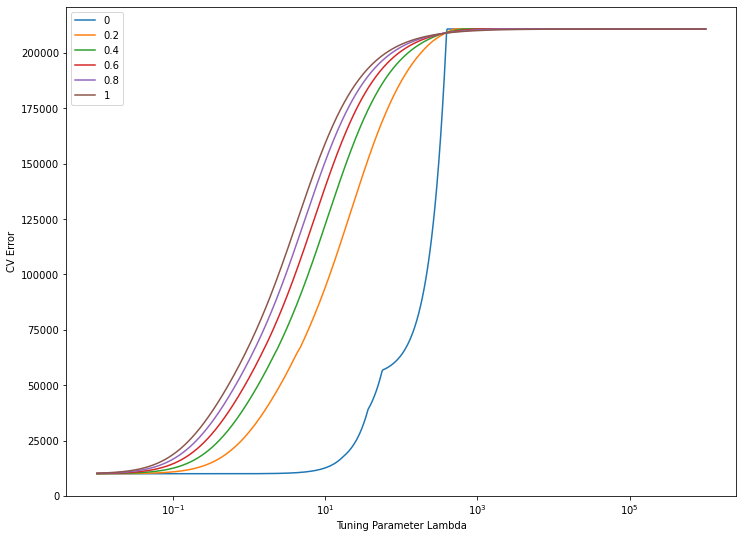

In [19]:
plt.figure(figsize=(12,9))
for alpha in alphas:
    plt.plot(lambdas, scores_sci[alpha], label=alpha)
    
plt.ylabel("CV Error")
plt.xlabel("Tuning Parameter Lambda")
plt.xscale("log")
plt.legend()
plt.show()

In [20]:
errors_list = deepcopy(scores_sci)

for alpha, errors in errors_list.items():
    min_idx = np.nanargmin(errors)
    print(f"alpha-{alpha} lambda-{lambdas[min_idx]} MSE-{errors[min_idx]}")

alpha-0 lambda-0.01 MSE-9991.719075436638
alpha-0.2 lambda-0.01 MSE-10013.904467692902
alpha-0.4 lambda-0.01 MSE-10054.320212068427
alpha-0.6 lambda-0.01 MSE-10108.199722258672
alpha-0.8 lambda-0.01 MSE-10175.575045602607
alpha-1 lambda-0.01 MSE-10255.892968411916


In [21]:
alpha = 0
lambda_ = 10E-2
model = ElasticNet(alpha=lambda_, l1_ratio=1-alpha)
model.fit(X.to_numpy(), y_true.to_numpy())
model.coef_

array([-274.51734818,  454.85433782,  160.88315647,   24.90580651,
        -10.86533726,   -3.41932436,  425.48798051,   -6.53029249,
          9.95604713])

## SciKit Implementation Results

In the CV Error plot we notice very similar trends for all values of alpha between the plots (particularly with alpha 0), however the SciKit implementation converges at a CV error 200,000+ at a
much lower lambda value than the manual implementation. I believe this is due to how the SciKit
CVGrid scores itself, which is difficult to expose and emulate due to the large amount of processing
done with the data.

The optimally performing alpha and lambda in the SciKit implementation are similar im magnitude
to the manual implementation, however the SciKit implementation chose an alpha value of 0 which
according to our CV error plot is more accurate. I believe this is due to the manual implementation’s
behavior at very low lambdas, which can be inconsistent.